<a href="https://colab.research.google.com/github/Nim-ah/MIE1624-Course-Project/blob/main/1624_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Some incorporated code and references:
https://www.kaggle.com/code/hansamaheshwari/twitter-sentiment-analysis-lr-hansa


# Part 1
## Data Pre-Processing

In [ ]:
df = pd.read_csv('sentiment_analysis.csv')
df.head()

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1


For part 2 you will need to load the text pre-processing code from here 


In [2]:
# Lower case all the text
def lowercase(tweet):
    return tweet.lower()

#Remove tags
def remove_tags(tweet):
    return re.sub("@[A-Za-z0-9_]+", '', str(tweet))

#Remove mentions
def remove_mentions(tweet):
    return re.sub("#[A-Za-z0-9_]+", '', str(tweet))

# Remove all URLs
def remove_url(tweet):
    urls = re.compile(r'\s*(?:https?:\/\/)?[\w.-]+(?:\.[\w.-]+)+[\w\-._~:/?#[\]@!\$&\'\(\)\*\+,;=.]+')
    return re.sub(urls, ' ', str(tweet))

#Token nize the string
def tokenize(tweet):
    tok_tweet = nltk.tokenize.word_tokenize(tweet)
    return ' '.join(tok_tweet)

#Remove rt in front of the string if starts with rt is detected
def remove_rt (tweet):
    x = re.search("^rt",tweet)
    if x:
        temp = re.sub("rt", '', str(tweet))
    else:
        temp = tweet
    return temp

#Remove stopwords
def remove_stopwords(tweet):
    words = tweet.split()
    clean_tweet = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(clean_tweet)

#remove non alphabatical numbers
def remove_nonAlphaNum(tweet):
    return re.sub(r'[^\s\w]+', '', tweet)

In [3]:


def clean(tweet):
    tweet = lowercase(tweet) 
    tweet = remove_tags(tweet)
    tweet = remove_mentions(tweet)
    tweet = remove_url(tweet)
    tweet = tokenize(tweet)
    tweet = remove_rt(tweet)
    tweet = remove_stopwords(tweet)
    tweet = remove_nonAlphaNum(tweet)
    return tweet


And stop here

In [ ]:
#Treat the raw string
df['Cleaned'] = df['text'].apply(clean)

#Delete ID column as it is not relevant
df.drop('ID',axis = 1)

,text,label,Cleaned
0,Josh Jenkins is looking forward to TAB Breeder...,1,josh jenkins looking forward tab breeders crow...
1,RT @MianUsmanJaved: Congratulations Pakistan o...,1,congratulations pakistan becoming world odds
2,"RT @PEPalerts: This September, @YESmag is taki...",1,september taking maine mendoza surprise tha...
3,"RT @david_gaibis: Newly painted walls, thanks ...",1,newly painted walls thanks million custodial...
4,RT @CedricFeschotte: Excited to announce: as o...,1,excited announce july 2017 feschotte lab rel...
...,...,...,...
550386,@goddesses_o I can't stop watching her...mm. M...,0,ca nt stop watching
550387,Poor old Tom Odell doesn't look like he would ...,0,poor old tom odell nt look like would know wro...
550388,#antsmasher I smashed 7 ants in this awesome ...,1,smashed 7 ants awesome game hjfjfi
550389,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1,morning girls wonderful


The cleaned csv file can be found here:https://utoronto-my.sharepoint.com/:x:/g/personal/yew_wang_mail_utoronto_ca/EdUeyO2A3alKlxrj8RxRMvMBqZKkc1bv6cghXCc68Jtwdg?e=uYOgCA

In [4]:
#Save cleaned dataset to csv and load in later step to save processing time
#df.to_csv('/cleaned_sentiment_analysis.csv', index=False)
cleaned_df = pd.read_csv('cleaned_sentiment_analysis.csv')

In [8]:
cleaned_df.dropna(inplace=True)

In [9]:
#Split the dataset into train-test and apply the TFIDF vectorization on training dataset
X_train, X_test, y_train, y_test = train_test_split(cleaned_df['Cleaned'], cleaned_df['label'], test_size=0.3, random_state=42)
# apply tf-idf and get the top 200 features
tfidf = TfidfVectorizer(lowercase=True, max_features = 200)
X_train_idf = tfidf.fit_transform(X_train) # only fit the training data    
X_test_idf = tfidf.transform(X_test)

In [10]:
X_train_idf = pd.DataFrame(X_train_idf.todense(), columns = tfidf.get_feature_names_out())
X_test_idf = pd.DataFrame(X_test_idf.todense(), columns = tfidf.get_feature_names_out())
X_train_idf.head(5)

,10,2016,also,always,amazing,amp,another,ass,awesome,baby,...,winter,wish,wonderful,work,world,would,wow,yall,year,years
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
def plot_roc_curve(y_true, y_score):
    # Compute false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    
    # Compute area under the ROC curve
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 8))
    # Plot ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()

## Logistic Regression

In [ ]:
clf = LogisticRegression().fit(X_train_idf, y_train)
# predict on train and test set
y_train_predict = clf.predict(X_train_idf)
y_test_predict = clf.predict(X_test_idf)
# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print(train_accuracy, test_accuracy)

0.8796230205594474 0.8797526617328214


With gridsearchCV and Cross-Validation

In [ ]:
#All the gridsearch cells should only be run once
'''
parameters = {'C':[0.01, 0.1, 1, 10, 100], 
              'solver':('liblinear','lbfgs', 'newton-cg'),
              'penalty':('none',  'l2')}

model = LogisticRegression()
cv = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
cv.fit(X_train_idf, y_train)

print('Best cross-validation score is :\n',cv.best_score_)
print('Best parameter:\n', cv.best_params_)
'''

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py", line 71, in _check_solver
    raise ValueError("penalty='none' is no

Best cross-validation score is :
 0.8792362747199425
Best parameter:
 {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}


In [11]:
# {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'} was determined to be the best hyperparameter set
bestLOGmodel = LogisticRegression(C = 10, penalty= 'l2', solver = 'newton-cg')
bestLOGmodel.fit(X_train_idf, y_train)
y_pred_LOG = bestLOGmodel.predict(X_test_idf)
LOG_f1 = f1_score(y_test, y_pred_LOG)
LOG_acc = accuracy_score(y_test, y_pred_LOG)
print("F1 Score Logistic Regression:",LOG_f1)
print("Accuracy Score Logistic Regression:",LOG_acc)

F1 Score Logistic Regression: 0.9069272400951642
Accuracy Score Logistic Regression: 0.8783903337615435


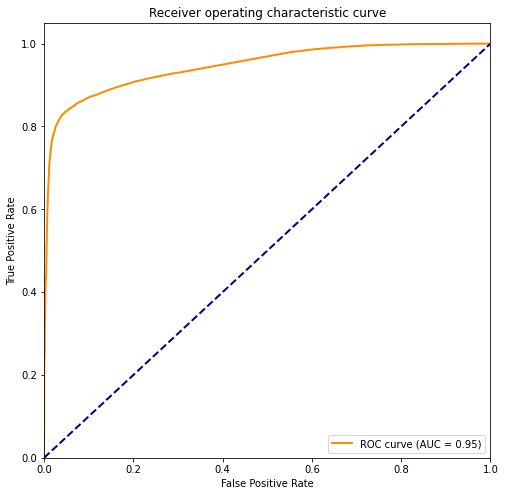

In [38]:
y_test_prob_LOG = bestLOGmodel.predict_proba(X_test_idf)
plot_roc_curve(y_test, y_test_prob_LOG[:, 1])

## Naive Bayes

In [36]:
clf = BernoulliNB().fit(X_train_idf, y_train)
# predict on train and test set
y_train_predict = clf.predict(X_train_idf)
y_test_predict = clf.predict(X_test_idf)
# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)
test_f1 = f1_score(y_test, y_test_predict)
print("F1 Score NB:",test_f1)
print("Accuracy Score NB:",test_accuracy)

F1 Score NB: 0.9010747749402903
Accuracy Score NB: 0.8694888140194391


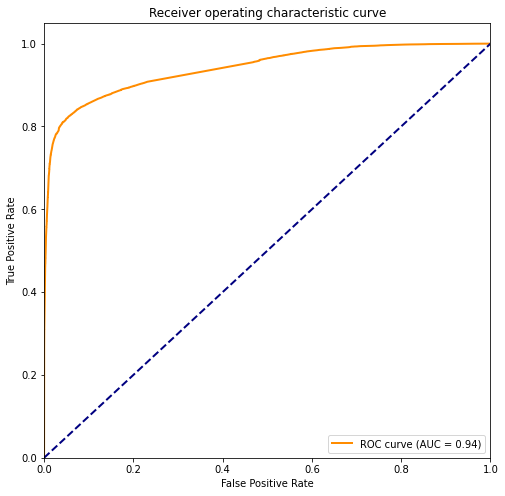

In [37]:
y_test_prob_NB = clf.predict_proba(X_test_idf)
plot_roc_curve(y_test, y_test_prob_NB[:, 1])

### SVM

With gridsearchCV and Cross-Validation

In [ ]:
#All the gridsearch cells should only be run once
'''
parameters = {'C':[0.001, 0.01, 0.1, 1, 10]}
model = LinearSVC(random_state=0, tol=1e-5)
cv = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
cv.fit(X_train_idf, y_train)

print('The best cross-validation score: ',cv.best_score_)
print('The best parameter:', cv.best_params_)
'''

The best cross-validation score:  0.8794179655833195
The best parameter: {'C': 1}


In [33]:
#C = 1 was the best hyper parameter
bestSVMmodel = LinearSVC(random_state=0, tol=1e-5, C = 1)
bestSVMmodel.fit(X_train_idf, y_train)
y_pred_SVM = bestSVMmodel.predict(X_test_idf)
SVM_f1 = f1_score(y_test, y_pred_SVM)
SVM_acc = accuracy_score(y_test, y_pred_SVM)
print("F1 Score SVM:",SVM_f1)
print("Accuracy Score SVM:",SVM_acc)


F1 Score SVM: 0.9070927018749532
Accuracy Score SVM: 0.8794144024044405


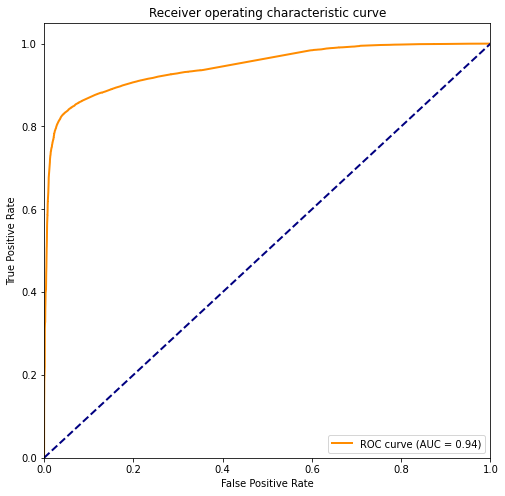

In [35]:
y_test_prob_SVM = bestSVMmodel._predict_proba_lr(X_test_idf)
plot_roc_curve(y_test, y_test_prob_SVM[:, 1])

### Random Forest

In [20]:
'''
parameters = {'min_samples_split':[ 10, 15, 20],
              'n_estimators':[50, 100, 200]}

model = RandomForestClassifier( random_state=0)
cv = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
cv.fit(X_train_idf, y_train)

print('The best cross-validation score: ',cv.best_score_)
print('The best parameter:', cv.best_params_)
'''

The best cross-validation score:  0.8859283497591315
The best parameter: {'min_samples_split': 20, 'n_estimators': 200}


Get accuracy and f1 socre on test set

In [22]:
#Using min sample split = 20 and n estimators = 200
bestRFmodel = RandomForestClassifier(min_samples_split = 20, n_estimators= 200, random_state=0)
bestRFmodel.fit(X_train_idf, y_train)
y_pred_RF = bestRFmodel.predict(X_test_idf)
RF_f1 = f1_score(y_test, y_pred_RF)
RF_acc = accuracy_score(y_test, y_pred_RF)
print("F1 Score Random Forest:",RF_f1)
print("Accuracy Score Random Forest:",RF_acc)


F1 Score Random Forest: 0.9131398348092483
Accuracy Score Random Forest: 0.8869525171486051


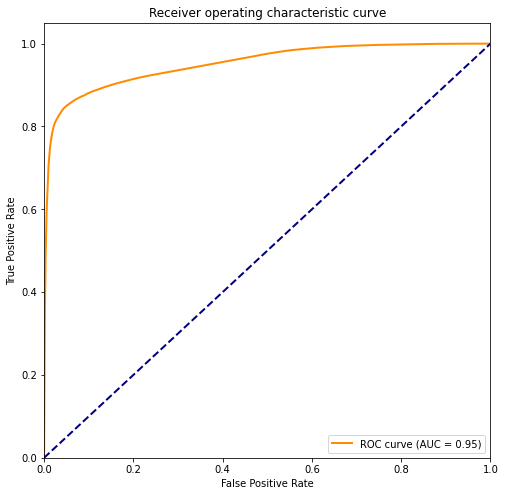

In [31]:
y_test_prob_RF = bestRFmodel.predict_proba(X_test_idf)
plot_roc_curve(y_test, y_test_prob_RF[:, 1])

Result Summary for part1

In [39]:
model_list = ['Logistic Regression', 'Naive Bayes', 'SVM', 'Random Forest']
f1_list = [LOG_f1, test_f1, SVM_f1, RF_f1]
acc_list = [LOG_acc, test_accuracy,SVM_acc, RF_acc]


In [40]:
result_df = pd.DataFrame({
    'Model': model_list,
    'F1 Score': f1_list,
    'Accuracy': acc_list
})
result_df

,Model,F1 Score,Accuracy
0,Logistic Regression,0.906927,0.878390
1,Naive Bayes,0.901075,0.869489
2,SVM,0.907093,0.879414
3,Random Forest,0.913140,0.886953


Based on F1 socre, Random Forest model with min_sample_split = 20, and 200 n_estimators performed the best, this model will be used in part 2.

# Part 2

In this part, our group will use newsAPI to collect the descriptions of news articles involve keywords: "russia", "ukraine", and "war". Then use the trained model from part 1 to perform Sentiment_Analysis on news descriptions to evaluate if it will be labeled as positive or negative.

In [ ]:
!pip install newsapi-python
import pandas as pd
from newsapi import NewsApiClient
from collections import Counter
import datetime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


*To save the api usage, the following cell should **only** be called when the sources or date needs to be modified. *

In [ ]:
# Initialize NewsAPI client
newsapi = NewsApiClient(api_key='4678da4b69ee46599f1280355d700b2e')

# Set query parameters
query = 'russia AND ukraine AND war' #keywords
language = 'en'
today = datetime.date.today()
from_date = (today - datetime.timedelta(days=25)).isoformat()

aggregated_list = []
list_of_news_sources = ['bbc-news','the-verge', 'abc-news','associated-press', 'bloomberg', 'business-insider', 'cbs-news', 'cnn',
                        'fortune','fox-news','google-news','msnbc','politico', 'reuters','the-wall-street-journal','the-washington-post','time','usa-today','wired']
# Retrieve articles
for src in list_of_news_sources:
  articles = newsapi.get_everything(q=query,
                                    sources=src,
                                    language=language,
                                    from_param=from_date,
                                    sort_by='relevancy')

  # Extract description text from articles
  descriptions = [article['description'] for article in articles['articles']]
  aggregated_list.extend(descriptions)

news_df = pd.DataFrame({
    'description': aggregated_list,

})
news_df['description'] = news_df['description'].astype(str)
news_df


The pre-processed news data should be loaded here in this step:

In [12]:
#news_df.to_csv('/news_description.csv', index=False)
news_df = pd.read_csv('news_description.csv')

In [14]:
#Treat the raw string
news_df['Cleaned'] = news_df['description'].apply(clean)


In [15]:
news_df

,description,Cleaned
0,The Russian ambassador said he wanted the UN t...,russian ambassador said wanted un commemorate ...
1,Steve Rosenberg looks at why Vladimir Putin se...,steve rosenberg looks vladimir putin set sail ...
2,Both Ukraine and Russia have reported inflicti...,ukraine russia reported inflicting significant...
3,Russia and China refused to condemn Moscow's i...,russia china refused condemn moscow s invasion...
4,"The resolution is approved by 141 countries, w...",resolution approved 141 countries seven incl...
...,...,...
1282,"Since Russia’s full-scale assault began, Ukrai...",since russia fullscale assault began ukraine...
1283,Plus: The US Marshals disclose a “major” cyber...,plus us marshals disclose major cybersecuri...
1284,Clearview AI is being used by the Ukrainian go...,clearview ai used ukrainian government identif...
1285,Digital traces including social posts and sear...,digital traces including social posts search q...


Fit the cleaned news data on the best model part 1 trained (Random Forest)

In [17]:
X_news_data = tfidf.fit_transform(news_df['Cleaned']) # fit-transform the vectorizer

In [53]:

y_pred_RF_news = bestRFmodel.predict(X_news_data)


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [67]:
def pie_plot(label):
  plt.figure(figsize=(8, 8))
  # count the number of positive and negative labels
  pos_count = np.count_nonzero(label)
  neg_count = len(label) - pos_count

  # calculate the percentages of positive and negative labels
  pos_percent = pos_count / len(label) * 100
  neg_percent = neg_count / len(label) * 100

  # create a pie chart
  fig, ax = plt.subplots()
  ax.pie([pos_percent, neg_percent], labels=['Positive', 'Negative'], autopct='%1.1f%%')
  ax.axis('equal')  # equal aspect ratio ensures that the pie is drawn as a circle
  ax.set_title('Percentage of Positive and Negative Labels')

  plt.show()

<Figure size 576x576 with 0 Axes>

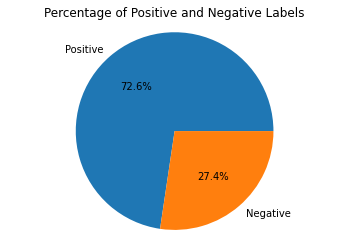

In [68]:
pie_plot(y_pred_RF_news)

Fit the cleaned news data on the NLTK pre-trained sentiment model to compare the result with our own model in part 1

In [61]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def add_sentiment_score(df, text_col):
    # create an instance of the SentimentIntensityAnalyzer class
    analyzer = SentimentIntensityAnalyzer()

    # loop through each row of the dataframe and calculate the compound sentiment score
    scores = []
    for i, row in df.iterrows():
        text = row[text_col]
        score = analyzer.polarity_scores(text)['compound']
        scores.append(score)

    # create a new column in the dataframe based on the compound sentiment score
    df['score'] = [1 if score > 0.5 else 0 for score in scores]

    return df




In [63]:
add_sentiment_score(news_df, 'Cleaned')

,description,Cleaned,score
0,The Russian ambassador said he wanted the UN t...,russian ambassador said wanted un commemorate ...,0
1,Steve Rosenberg looks at why Vladimir Putin se...,steve rosenberg looks vladimir putin set sail ...,0
2,Both Ukraine and Russia have reported inflicti...,ukraine russia reported inflicting significant...,0
3,Russia and China refused to condemn Moscow's i...,russia china refused condemn moscow s invasion...,0
4,"The resolution is approved by 141 countries, w...",resolution approved 141 countries seven incl...,0
...,...,...,...
1282,"Since Russia’s full-scale assault began, Ukrai...",since russia fullscale assault began ukraine...,0
1283,Plus: The US Marshals disclose a “major” cyber...,plus us marshals disclose major cybersecuri...,0
1284,Clearview AI is being used by the Ukrainian go...,clearview ai used ukrainian government identif...,0
1285,Digital traces including social posts and sear...,digital traces including social posts search q...,0


<Figure size 576x576 with 0 Axes>

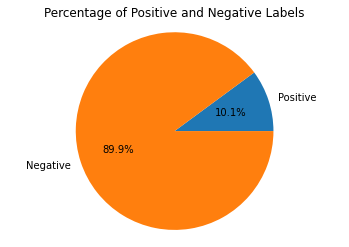

In [69]:
pie_plot(news_df['score'])